In [ ]:
import sys
!{sys.executable} -m pip install qiskit['visualization']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 K

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator, Aer, AerSimulator
from qiskit.visualization import plot_histogram
from random import randint
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [ ]:
# Generating Alice's classical message
n = 10
Alice_message = []
for i in range(0,n):
    Alice_message.append(randint(0,1))

# Generating Alice's encoding key
Alice_encrypting = []
for i in range(0,n):
    Alice_encrypting.append(randint(0,1))
Alice_encrypting,Alice_message

In [ ]:
circuit = QuantumCircuit(n)
for i in range(n):
    circuit.initialize([1,0],i)
for i in range(n):
    if (Alice_encrypting[i] == 1 and Alice_message[i] == 1):
        circuit.x(i)
        circuit.h(i)
    elif (Alice_encrypting[i] == 0 and Alice_message[i] == 1):
        circuit.x(i)
    elif (Alice_encrypting[i] == 1 and Alice_message[i] == 0):
        circuit.h(i)

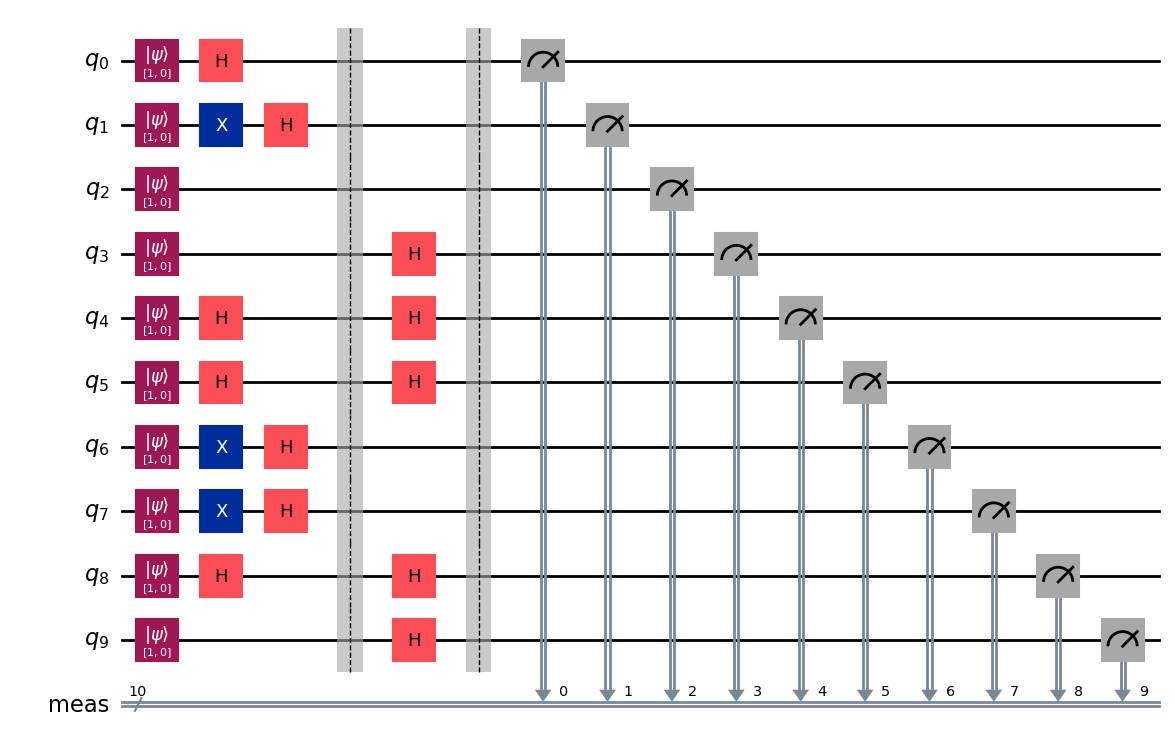

In [ ]:
# Generating Bob's decrypting key

Bob_decryption = []
for i in range(n):
    Bob_decryption.append(randint(0,1))
circuit.barrier()
for i in range(0,n):
    if Bob_decryption[i] == 1:
        circuit.h(i)
        
circuit.measure_all()
circuit.draw('mpl', style='iqx')

In [ ]:
simulator =  Aer.get_backend('aer_simulator')
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots = 1) # circuit on qasm simulator
result = job.result() # returns the result of simulation with 1000 shots

In [ ]:
measure = result.get_counts(compiled_circuit)
Bob_message_array = np.empty(n)

for key in measure.keys():
    Bob_message_string_dummy = key
    for i in range(n):
        Bob_message_array[i] = int(Bob_message_string_dummy[n-1-i])
        # It has put n-1-i because Qiskit inverts the reading order so the last element should be inverted -> SWAP
        
Bob_message_string = []
for i in range(0,len(Bob_message_array)):
    Bob_message_string.append(int(Bob_message_array[i]))  

In [ ]:
true_mex = np.full(n,-1)
#true_mex

In [ ]:
for i in range(0, len(Alice_encrypting)):
    if Alice_encrypting[i] == Bob_decryption[i]:
        true_mex[i] = Bob_message_string[i]


In [ ]:
def BER(Alice_message, Alice_encrypting, Bob_message_string, Bob_decryption):
    failed_bit = 0
    counter=0
    for i in range(0, len(Alice_encrypting)):
        if Alice_encrypting[i] == Bob_decryption[i]:
            counter +=1
            if Alice_message[i] != Bob_message_string[i]:
                failed_bit += 1
    if counter == 0:
        return 0
    return failed_bit/counter
b=BER(Alice_message,Alice_encrypting,Bob_message_string,Bob_decryption)
[b,Alice_message,Alice_encrypting,Bob_message_string,Bob_decryption,true_mex]

In [ ]:
def check_mex(true_mex):
    for i in range(0,len(true_mex)):
        if true_mex[i] == -1:
            return False
    return True

In [ ]:
def setup_circuit(message_length):
    count = 0
    bit_error_rate=0
    Alice_message_string = []
    for i in range(0,message_length):
        Alice_message_string.append(randint(0,1))

    # Initializing the true message that will be compared
    true_mex = np.full(message_length,-1)
    #true_mex
    while check_mex(true_mex) == False:
        count += 1
        Alice_encrypting = []
        for i in range(0,message_length):
            Alice_encrypting.append(randint(0,1))
        circuit = QuantumCircuit(message_length,message_length)
        for i in range(0,message_length):
            if (Alice_encrypting[i] == 1 and Alice_message_string[i] == 1):
                circuit.x(i)
                circuit.h(i)
            elif (Alice_encrypting[i] == 0 and Alice_message_string[i] == 1):
                circuit.x(i)
            elif (Alice_encrypting[i] == 1 and Alice_message_string[i] == 0):
                circuit.h(i)
            
        # Generating Bob's key
        Bob_decryption = []
        circuit.barrier()
        for i in range(0,message_length):
            Bob_decryption.append(randint(0,1))
            if Bob_decryption[i] == 1:
                circuit.h(i)    
        circuit.measure_all()

        t_qc = transpile(circuit, backend=backend)
        job = backend.run(t_qc, shots=1)
        result = job.result()
        measure = result.get_counts(t_qc)

        Bob_message_array = np.empty(message_length)
        for key in measure.keys():
            Bob_message_string_dummy = key
            for i in range(message_length):
                Bob_message_array[i] = int(Bob_message_string_dummy[message_length-1-i])
        Bob_message_string = []
        for i in range(0,len(Bob_message_array)):
            Bob_message_string.append(int(Bob_message_array[i]))
        for i in range(0, len(Alice_encrypting)):
            if Alice_encrypting[i] == Bob_decryption[i]:
                true_mex[i] = Bob_message_string[i]
  
        bit_error_rate += BER(Alice_message_string, Alice_encrypting, Bob_message_string, Bob_decryption)

    bit_error_rate/=count
    return [count, bit_error_rate]

C:\Users\checc\AppData\Local\Temp\ipykernel_4336\3910670913.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


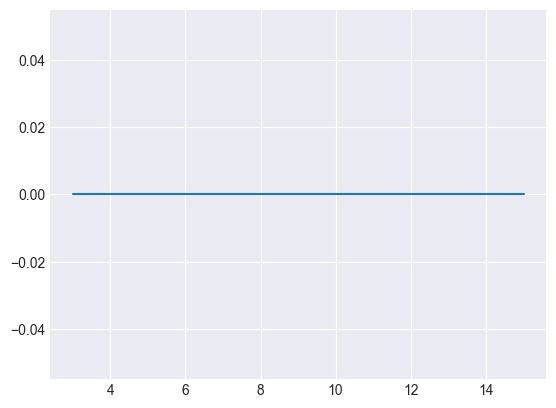

In [ ]:
ber_mean = np.zeros(5)
ber_avg = np.zeros(10)
message_dim = np.linspace(3,15,5)
for i in range(len(ber_mean)):
    for j in range(0,10):
        ber_avg[j] = setup_circuit(3*i+3)[1]
    ber_mean[i] = ber_avg.mean()
fig = plt.plot(message_dim, ber_mean)